# ASHR/CHAD Performance Analysis

### Get Source Data

In [41]:
%matplotlib inline
# Get Source Data
from agents.xueqiu.api import *
xueqiu = XueqiuAPI()
hs300 = xueqiu.stock_k_day("SH000300", begin="2015-01-01 00:00:00")
print("HS300: Totally %d items loaded since %s" % (len(hs300), hs300[0]['time']))
ashr = xueqiu.stock_k_day("ASHR", begin="2015-01-01 00:00:00")
print("ASHR: Totally %d items loaded since %s" % (len(ashr), ashr[0]['time']))
chad = xueqiu.stock_k_day("CHAD", begin="2015-01-01 00:00:00")
print("CHAD: Totally %d items loaded since %s" % (len(chad), chad[0]['time']))

HS300: Totally 204 items loaded since Mon Jan 05 00:00:00 +0800 2015
ASHR: Totally 213 items loaded since Fri Jan 02 00:00:00 +0800 2015
CHAD: Totally 99 items loaded since Wed Jun 17 00:00:00 +0800 2015


### Data Clean

In [42]:
from datetime import datetime
for target in (hs300, ashr, chad):
    for each in target:
        each['date'] = datetime.strptime(each['time'], "%a %b %d %H:%M:%S +0800 %Y").date()

### Draw The Performance Of HS300 / ASHR / CHAD

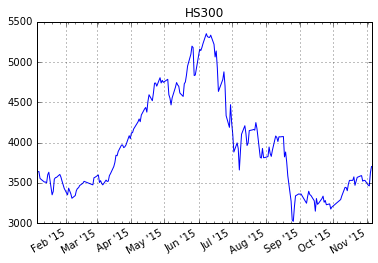

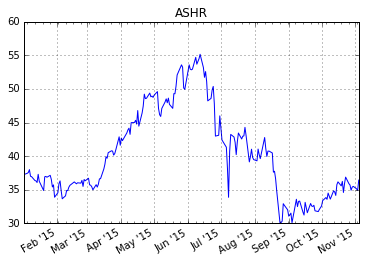

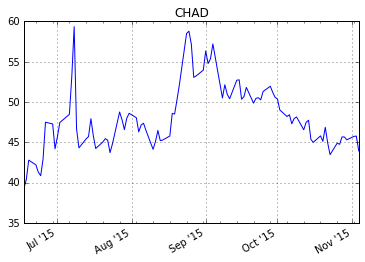

In [43]:
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MONDAY
#from matplotlib.finance import quotes_historical_yahoo_ochl
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

# lines: [{"value":[...], "label":"..."}]
def draw_line(title, dates, lines):
    # every monday
    mondays = WeekdayLocator(MONDAY)

    # every 3rd month
    months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
    monthsFmt = DateFormatter("%b '%y")


    quotes = hs300
    if len(quotes) == 0:
        print('Found no quotes')
        raise SystemExit

    fig, ax = plt.subplots()
    ax.set_title(title)
    for line in lines:
        val = line['value']
        del line['value']
        ax.plot_date(dates, val, '-', **line)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.xaxis.set_minor_locator(mondays)
    ax.autoscale_view()
    #ax.xaxis.grid(False, 'major')
    #ax.xaxis.grid(True, 'minor')
    ax.grid(True)
    fig.autofmt_xdate()
    plt.show()

draw_line("HS300", [q['date'] for q in hs300], [{"value":[q['close'] for q in hs300]}])
draw_line("ASHR", [q['date'] for q in ashr], [{"value":[q['close'] for q in ashr]}])
draw_line("CHAD", [q['date'] for q in chad], [{"value":[q['close'] for q in chad]}])

### Calculate The Bias of ASHR / CHAD Compared With HS300

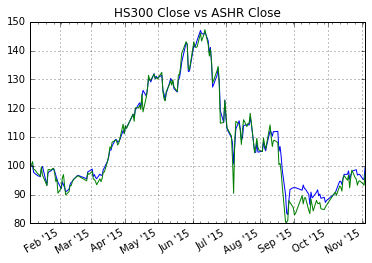

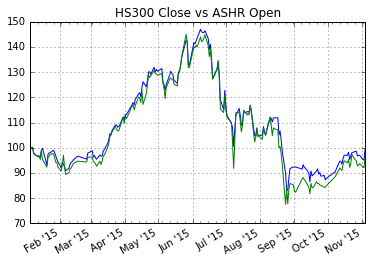

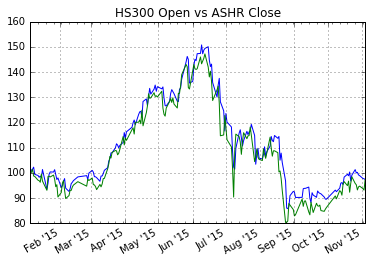

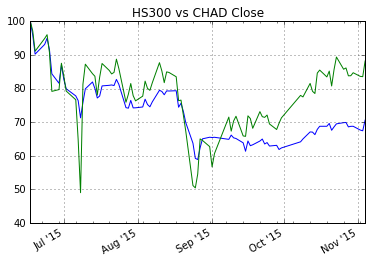

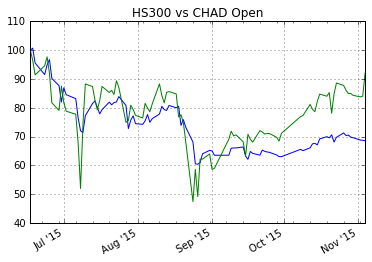

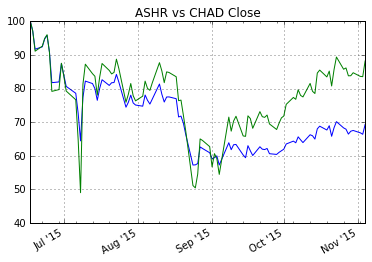

In [53]:
def unify_sources(source1, source2, start_value=100.0, field="close", field2=None, reverse=False, start_date=None):
    result1 = []
    result2 = []
    dates = []
    i1 = iter(source1)
    i2 = iter(source2)
    a1 = i1.__next__()
    a2 = i2.__next__()
    ratio1 = 1
    ratio2 = 1
    first = True
    if not field2:
        field2 = field
    try:
        while True:
            if a1['date'] < a2['date']:
                a1 = i1.__next__()
                continue
            elif a1['date'] > a2['date']:
                a2 = i2.__next__()
                continue
            else: # a1['date'] == a2['date']
                # The date is shared by the two sources
                dates.append(a1['date'])
                if first:
                    ratio1 = a1[field] / start_value
                    ratio2 = a2[field2] / start_value
                    first = False
                result1.append(a1[field] / ratio1)
                if reverse is False:
                    result2.append(a2[field2] / ratio2)
                else:
                    result2.append(2*start_value - a2[field2] / ratio2)
                
                
                a1 = i1.__next__()
                a2 = i2.__next__()
    except StopIteration:
        pass
    return (dates, result1, result2)

(dates, hs300_unify, ashr_unify) = unify_sources(hs300, ashr, field="close")
draw_line("HS300 Close vs ASHR Close", dates, [{"value":hs300_unify, "label":"HS300"}, {"value":ashr_unify, "label":"ASHR"}])

(dates, hs300_unify, ashr_unify) = unify_sources(hs300, ashr, field="close", field2="open")
draw_line("HS300 Close vs ASHR Open", dates, [{"value":hs300_unify, "label":"HS300"}, {"value":ashr_unify, "label":"ASHR"}])

(dates, hs300_unify, ashr_unify) = unify_sources(hs300, ashr, field="open", field2="close")
draw_line("HS300 Open vs ASHR Close", dates, [{"value":hs300_unify, "label":"HS300"}, {"value":ashr_unify, "label":"ASHR"}])

(dates, hs300_unify, chad_unify) = unify_sources(hs300, chad, reverse=True, field="close")
draw_line("HS300 vs CHAD Close", dates, [{"value":hs300_unify, "label":"HS300"}, {"value":chad_unify, "label":"CHAD"}])

(dates, hs300_unify, chad_unify) = unify_sources(hs300, chad, reverse=True, field="open")
draw_line("HS300 vs CHAD Open", dates, [{"value":hs300_unify, "label":"HS300"}, {"value":chad_unify, "label":"CHAD"}])

(dates, ashr_unify, chad_unify) = unify_sources(ashr, chad, reverse=True, field="close")
draw_line("ASHR vs CHAD Close", dates, [{"value":ashr_unify, "label":"ASHR"}, {"value":chad_unify, "label":"CHAD"}])


**From the above result we have two conclusions:**
* Leverage ETF like CHAD is not suitable for long-term hedge.
* To use ASHR short position to hedge, using daily close price is better than open price.